# Prédiction de l'appétence à un produit bancaire - Sélection du modèle

Dans un premier temps, nous avons étudié les données fournies par la banque et avons construit des features permettant d'en extraire de l'information de la manière la plus susceptible d'être utile à un algorithme d'apprentissage.

Ici, nous proposons et justifions un choix d'algorithme particulier, que nous allons entraîner et optimiser.

In [1]:
import sys
sys.path.append("/Users/OlivierCollier/productsubscription-oc-jk/")

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_confusion_matrix

from src.infrastructure.build_dataset import DataBuilderFactory, DataMerger
from src.domain.cleaning import MissingValueTreatment
from src.domain.build_features import feature_engineering_transformer

###################
## AVERTISSEMENT ##
###################

# Les constantes utilisées dans ce notebook sont hard-codées. Dans les autres fichiers du projet, 
# elles sont extraites des fichiers config/base.py et config/column_names.py.
# Cependant, dans un souci de clarté et de facilité de lecture, nous souhaitons éviter au lecteur 
# de ce notebook de devoir systématiquement se reporter à leurs contenus.

## 1) Création des données

Deux jeux de données nous ont été fournis : l'un dont chaque ligne correspond à un contact (ou une série de contacts) avec un client, et l'autre apportant des informations contextuelles sur la situation économique du pays et de la période concernés.

Tout d'abord, nous préprocessons ces deux jeux de données séparément. En effet, il est plus facile de traiter les données manquantes dans le fichier de données économiques, qui contient des valeurs mensuelles, que dans le fichier de clients, où chaque ligne est associée à une date précise.

Ce traitement comprend :
- la reconnaissance colonne par colonne des formats de données (entiers, dates, objets...),
- la traduction des mots français afin d'uniformiser la langue à travers les données,
- la suppression de lignes possédant trop de valeurs manquantes (quand à la fois AGE et JOB_TYPE ne sont pas renseignés),
- pour les données économiques, la complétion des données manquantes par interpolation,
- pour les données relatives aux clients, la correction d'erreurs évidentes.

Ensuite, les données sont agrégées suivant une colonne MOIS/ANNEE qui est crée pendant le traitement et supprimée tout de suite après l'agrégation. 

Enfin, on sépare la cible (y) du reste des données (X).

In [3]:
# Loading config values
client_file = '../../data/raw/data.csv' ### data/raw/train !!
eco_file = '../../data/raw/socio_eco.csv'
config_client_data =  {'name': 'data.csv',
                       'date_format': '%Y-%m-%d',
                       'date_column': 'DATE',
                       'sep': ';',
                       'cast_types': {'DATE': 'datetime64', 'AGE': 'int64', 'BALANCE': 'float64'},
                       'wrong_entries': {'AGE': 123},
                       'filters': {'missing': ['AGE','JOB_TYPE']}
}
config_eco_data = {'name': 'socio_eco.csv',
                   'date_format': '%Y-%m-%d',
                   'date_column': 'DATE',
                   'sep': ';',
                   'cast_types': {'DATE': 'datetime64'},
                   'filters': {'missing': []}    
}
JOB_TYPE_TRANSLATION = {
    'Technicien': 'Technician',
    'Entrepreuneur': 'Entrepreneur',
    'Col bleu': 'Blue-collar worker',
    'Retraité': 'Retired',
    'Indépendant': 'Freelance',
    'Chomeur': 'Unemployed',
    'Employé de ménage': 'House keeper',
    'Etudiant': 'Student'
}
EDUCATION_TRANSLATION = {
    'Tertiaire': 'Graduate studies',
    'Secondaire': 'Secondary education',
    'Primaire': 'Primary education'
}
MARITAL_STATUS_TRANSLATION = {
    'Marié': 'Married',
    'Célibataire': 'Single',
    'Divorcé': 'Divorced'
}
RESULT_LAST_CAMPAIGN_TRANSLATION = {
    'Echec': 'Fail',
    'Autre': 'Other',
    'Succes': 'Success'
}
ALL_CLIENT_DATA_TRANSLATION = {
    'JOB_TYPE': JOB_TYPE_TRANSLATION,
    'EDUCATION': EDUCATION_TRANSLATION,
    'STATUS': MARITAL_STATUS_TRANSLATION,
    'RESULT_LAST_CAMPAIGN': RESULT_LAST_CAMPAIGN_TRANSLATION
}
MERGER_FIELD = 'YEAR-MONTH'

# Preprocessing client data
client_builder = DataBuilderFactory(client_file, 
                                    config_client_data, 
                                    ALL_CLIENT_DATA_TRANSLATION)
client_data = client_builder.transform('client')

# Preprocessing eco data
eco_builder = DataBuilderFactory(eco_file, 
                                 config_eco_data)
eco_data = eco_builder.transform('eco')

# Merging files to final dataset
X, y = DataMerger(client_data, eco_data, MERGER_FIELD).transform()
y = y.eq('Yes').astype(int)

========== Processing client data ==========
- Casting types.
- Translating French words to English.
- Dropping rows with too many missing values.
- Correcting erroneous entries.
========== Processing eco data ==========
- Casting types.
- Translating French words to English.
- Dropping rows with too many missing values.
- Imputing missing data.
========== Merging datasets ==========
========== Separating target from explanatory variables ==========


In [4]:
tmp1 = X.IDX_CONSUMER_PRICE
tmp2 =X.IDX_CONSUMER_CONFIDENCE
X.drop(columns= 'IDX_CONSUMER_PRICE', inplace=True)
X.drop(columns= 'IDX_CONSUMER_CONFIDENCE', inplace=True)
import pandas as pd
X = pd.concat([X, tmp1, tmp2], axis=1)
X

,DATE,AGE,JOB_TYPE,STATUS,EDUCATION,HAS_DEFAULT,BALANCE,HAS_HOUSING_LOAN,HAS_PERSO_LOAN,CONTACT,DURATION_CONTACT,NB_CONTACT,NB_DAY_LAST_CONTACT,NB_CONTACT_LAST_CAMPAIGN,RESULT_LAST_CAMPAIGN,EMPLOYMENT_VARIATION_RATE,IDX_CONSUMER_PRICE,IDX_CONSUMER_CONFIDENCE
0,2008-05-05,58.0,Manager,Married,Graduate studies,No,2143.0,Yes,No,NaN,261,1,-1,0,NaN,1.1,93.994,-36.4
1,2008-05-05,NaN,Technician,NaN,Secondary education,No,29.0,Yes,NaN,NaN,151,1,-1,0,NaN,1.1,93.994,-36.4
2,2008-05-05,33.0,Entrepreneur,Married,Secondary education,No,2.0,Yes,Yes,NaN,76,1,-1,0,NaN,1.1,93.994,-36.4
3,2008-05-05,47.0,Blue-collar worker,Married,NaN,No,1506.0,Yes,No,NaN,92,1,-1,0,NaN,1.1,93.994,-36.4
4,2008-05-05,33.0,NaN,Single,NaN,No,1.0,No,No,NaN,198,1,-1,0,NaN,1.1,93.994,-36.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45131,2010-10-27,47.0,Manager,Married,Graduate studies,No,0.0,No,No,Portable,508,1,-1,0,NaN,-1.1,94.601,-49.5
45132,2010-10-27,61.0,Retired,Married,Secondary education,No,1058.0,No,No,Portable,277,1,92,5,Success,-1.1,94.601,-49.5
45133,2010-10-27,24.0,Student,Single,Secondary education,No,822.0,No,No,Portable,184,1,91,2,Fail,-1.1,94.601,-49.5
45134,2010-10-27,70.0,Retired,Married,Secondary education,No,0.0,No,No,Portable,258,1,92,5,Success,-1.1,94.601,-49.5


# 2) Création des ensembles d'entraînement et de test

Nous divisons maintenant les données aléatoirement en un ensemble d'apprentissage, qui nous servira pour entraîner le modèle, et un ensemble de test, sur lequel nous l'évaluerons. Nous fixons arbitrairement la valeur de la graine du générateur aléatoire afin d'obtenir des résultats reproductibles.

Etant donné que les deux classes à prédire sont particulièrement déséquilibrées -- il y a environ 9 fois plus d'échantillons négatifs que de positifs, il est important d'utiliser l'option stratify, qui permet de s'assurer qu'une répartition proche sera observée à la fois dans l'ensemble d'entraînement et dans celui de test.

In [5]:
# Splitting train and test

random_state = 21

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=random_state)

## 3) Création du pipeline

D'autre part, nous définissons sous forme d'un pipeline scikit-learn l'ensemble des transformations qui doivent être appliquées aux données, puis passées à un classifieur. On distingue trois composantes dans ce pipeline.

#### a) Traitement des valeurs manquantes

Les tâches suivantes sont effectuées à travers la classe MissingValueTreatment :
- complétion de la variable JOB_TYPE par AGE lorsque c'est possible ; on attribue la catégorie "Student" aux moins de 25 ans, la catégorie "Retired" aux plus de 60 ans, et la catégorie majoritaire aux autres (un choix plus précis ne changerait presque rien au reste de notre méthode),
- complétion des valeurs manquantes des autres variables à l'aide de JOB_TYPE (la valeur majoritaire parmi les éléments de la même catégorie professionnelle pour les variables catégoriques, et la médiane pour les variables continues).

#### b) Construction des descripteurs

Les descripteurs suivants sont calculés par le transformeur feature_engineering_transformer :
- une version clippée entre -4000 et 4000 de ACCOUNT_BALANCE, puis réduite par division par 8000,
- des versions clippées entre 0 et 15 de NB_CONTACTS_CURRENT_CAMPAIGN et NB_CONTACTS_BEFORE_CAMPAIGN, puis réduites par division par 15,
- des encodages one-hot des variables HAS_HOUSING_LOAN, HAS_PERSO_LOAN, HAS_DEFAULT, MARITAL_STATUS et EDUCATION,
- l'indicatrice valant 1 quand JOB_TYPE vaut "Retired",
- l'indicatrice valant 1 quand RESULT_LAST_CAMPAIGN vaut "Success",
- l'indicatrice valant 1 quand MARITAL_STATUS vaut "Single",
- les indicatrices valant 1 respectivement quand AGE est supérieur à 25 et 60,
- une version normalisée de la variable AGE par StandardScaler,
- une version encodée par target encoding de la variable MONTH, elle-même extraite de DATE,
- une variable valant 1 si HAS_HOUSING_LOAN et HAS_PERSO_LOAN valent 1, et 0 sinon,
- les variables socio-économiques du tableau supplémentaire, avec une normalisation utilisant StandardScaler.

#### c) Classification

Nous avons choisi d'utiliser un classifieur par forêt aléatoire pour plusieurs raisons :
- notre expérimentation préliminaire nous a montré que les résultats étaient nettement supérieurs avec cette méthode : une dizaine de centième pour l'aire sous la courbe précision-rappel (nous justifierons le choix de ce critère plus loin),
- la bonne interprétabilité de ce modèle grâce à la Mean Decrease Impurity implémentée dans la méthode feature_importances_ de RandomForestClassifier,
- la disponibilité d'outils d'intelligibilité dédiés aux forêts aléatoires, permettant de mieux expliquer notre méthode au client.

In [6]:
# Constructing global pipeline

steps = [
    ('imputation', MissingValueTreatment()),
    ('feature_engineering', feature_engineering_transformer()),
    ('rf_clf', RandomForestClassifier())
]

pipeline = Pipeline(steps=steps)

## 4) Optimisation du modèle

Une fois ce cadre choisi, on peut optimiser les paramètres de notre forêt aléatoire. Pour ce faire, nous avons d'abord essayé chaque paramètre de RandomForestClassifier et déterminé lesquels avaient un vrai impact, puis avec une approche gloutonne, nous avons recherché des zones plus favorables pour chacun de ces paramètres.

Nous en avons déduit un ensemble de paramètres que nous souhaitons tester avec une recherche aléatoire par RandomizedSearchCV. Nous devons alors définir un critère de scoring adapté à notre problème. Or, dans cette étude, il s'agit de maximiser la proportion d'appels fructueux et le nombre de clients intéressés qui sont effectivement contactés, c'est-à-dire la précision et le rappel. Nous choisissons donc d'optimiser une fonction de ces deux quantités : l'aire sous la courbe précision-rappel, qui correspond à l'argument scoring='average_precision' dans la fonction RandomizedSearchCV. 

Enfin, nous avons utilisé le paramètre class_weight pour donner un poids plus important à la classe minoritaire, inversement proportionnellement à sa représentation dans les données.

In [21]:
param_distributions = {
    'rf_clf__n_estimators': [220, 240, 260, 280, 300],
    'rf_clf__max_depth': [6, 7, 8, 9, 10],
    'rf_clf__min_samples_leaf': [9, 10, 11, 12]
}
class_weight = {1: 9, 0: 1}
random_state = 21

clf = RandomizedSearchCV(estimator=pipeline, 
                         param_distributions=param_distributions,
                         scoring='average_precision', 
                         random_state=random_state, 
                         cv=5)
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

KeyboardInterrupt: 

## 5) Evaluation du modèle

In [22]:
# Pour ne pas avoir à attendre la fin de l'optimisation précédente, on pourra décommenter 
# les lignes suivantes et changer directement le modèle sauvegardé en format pickle.
# import pickle
# opt_pipeline = pickle.load(open("../../models/ml_model.pkl", "rb"))

# Il faut alors également commenter la ligne suivante.
opt_pipeline = clf.best_estimator_

Notre modèle final est donc une forêt aléatoire implémentée dans RandomForestClassifier, avec pour arguments (hors arguments par défaut) :
- n_estimators = 220,
- max_depth = 10,
- min_samples_leaf = 10.

On peut éprouver la performance de l'algorithme en visualisant la matrice de confusion.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

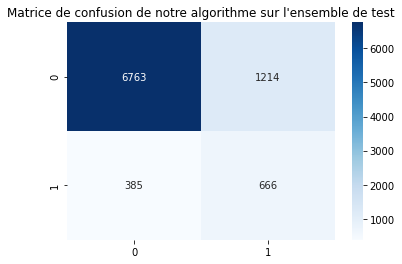

In [48]:
y_pred = opt_pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
labels = np.asarray(conf_matrix.flatten()).reshape(2,2)
sns.heatmap(data=conf_matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Matrice de confusion de notre algorithme sur l'ensemble de test")
plt.show()

On constate tout d'abord que la performance n'est pas très bonne : sur 1051 personnes intéressées, seules 666 ont été détectées, et 1214 seront contactées en vain. Cependant, les features dont nous disposons ne semblent pas très corrélés avec la cible, et il nous semble qu'aucun prédicteur ne pourra atteindre une très bonne performance.

D'autre part, nous traçons la courbe de précision-rappel :

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

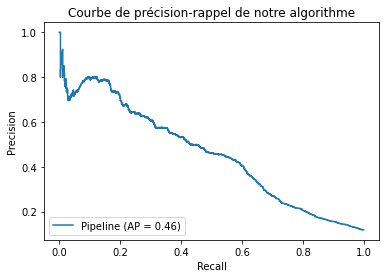

In [36]:
plot_precision_recall_curve(opt_pipeline, X_test, y_test)
plt.title("Courbe de précision-rappel de notre algorithme")
plt.show()

In [51]:
dir(opt_pipeline)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_inverse_transform',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_required_parameters',
 '_set_params',
 '_transform',
 '_validate_names',
 '_validate_steps',
 'classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inverse_transform',
 'memory',
 'named_steps',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'score',
 'score_samples',
 'set_para

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, opt_pipeline.predict_proba(X_test)[:, 1]) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676

L'aire sous cette courbe, que nous nous proposions de maximiser, est égale à 0,46. 

In [ ]:
courbe precision-recall
aire sous la courbe
matrice de confusion
cumulative_gain / lift

In [ ]:
On trace sa courbe précision-rappel à partir des prédictions de l'algorithme sur les données de test. 